# Full Ephemeris — Honest NN + Trading Check (No Test Tuning)

**Goal (simple):**

- We want to know if the strong-looking trading curve from an `MLP` is a real edge, or just an accident from tuning on the TEST period.

**The main trap we avoid:**

- If we choose trading parameters (stop-loss, neutral-zone thresholds, etc.) by looking at TEST,
  we can often create an impressive equity curve even from a weak or random signal.

**Honest protocol (what we do here):**

1. Train the model on **TRAIN**.
2. Tune classification threshold and trading parameters using **VALIDATION only**.
3. Freeze everything.
4. Evaluate once on **TEST**.

**Models we compare (pragmatic choice):**

- `xgb` and `rf` are strong tabular baselines.
- `sklearn_mlp` is the simple neural net we already use.
- `keras_mlp` is a slightly more flexible neural net (dropout + L2) to test whether a better regularized NN can help.

We keep the model list short on purpose:
- too many models/variants = many comparisons = more false positives.

In [1]:
# ------------------------------
# Imports and project path setup
# ------------------------------

from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path('/home/rut/ostrofun')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_sample_weight

import tensorflow as tf

from RESEARCH2.Moon_cycles.moon_data import (
    MoonLabelConfig,
    load_market_slice,
    build_moon_dataset_for_gauss,
    get_moon_feature_columns,
)
from RESEARCH2.Moon_cycles.splits import make_classic_split
from RESEARCH2.Moon_cycles.ephemeris_data import (
    EphemerisFeatureConfig,
    build_ephemeris_feature_set,
)
from RESEARCH2.Moon_cycles.eval_utils import (
    compute_binary_metrics,
    compute_statistical_significance,
)
from RESEARCH2.Moon_cycles.threshold_utils import tune_threshold_with_balance, predict_proba_up_safe

from RESEARCH.model_training import train_xgb_model, check_cuda_available
from RESEARCH2.Moon_cycles.eval_visuals import VisualizationConfig
from RESEARCH2.Moon_cycles.trading_utils import (
    TradingConfig,
    backtest_long_flat_signals,
    build_signal_from_proba,
    plot_backtest_price_and_equity,
)

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 160)

print('tf version:', tf.__version__)


2026-02-05 12:40:09.053686: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-05 12:40:09.624285: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-05 12:40:22.879040: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


tf version: 2.20.0


In [2]:
# ------------------------------
# Configuration
# ------------------------------

# Market range.
START_DATE = '2017-11-01'
END_DATE = None

# Feature mode: full ephemeris.
ORB_MULT = 0.25  # you can change this after v3 finds a better orb
CACHE_NAMESPACE = 'research2_ephem'  # orb=0.25 baseline cache

# Label config.
LABEL_CFG = MoonLabelConfig(
    horizon=1,
    move_share=0.5,
    label_mode='balanced_detrended',
    price_mode='raw',
)

# We fix one gaussian label config here to keep the notebook focused.
# If you want, you can replace this with the best gauss from bakeoff.
GAUSS_WINDOW = 201
GAUSS_STD = 40.0

# Threshold tuning penalties (validation-only).
THRESHOLD_GAP_PENALTY = 0.25
THRESHOLD_PRIOR_PENALTY = 0.05

# Trading params grid (tuned on VALIDATION only).
FEE_RATE = 0.001
STOP_LOSSES = [0.0, 0.01, 0.02, 0.03, 0.05, 0.08]
EXIT_ON_NO_SIGNAL_OPTIONS = [False, True]

# Neutral-zone width around 0.50.
# delta=0.00 -> always decide (0.50/0.50)
# delta=0.02 -> (0.52/0.48)
NEUTRAL_DELTAS = [0.00, 0.005, 0.01, 0.02, 0.03]

# Visual style (dark theme) for trading plots.
VIS_CFG = VisualizationConfig(
    rolling_window_days=90,
    rolling_min_periods=30,
    probability_bins=64,
)

USE_CACHE = True
VERBOSE = True
XGB_USE_CUDA, XGB_DEVICE = check_cuda_available()


def make_ephem_cfg(orb_mult: float) -> EphemerisFeatureConfig:
    """Build a full-ephemeris config for a given orb multiplier."""

    return EphemerisFeatureConfig(
        coord_mode='both',
        orb_mult=float(orb_mult),
        include_pair_aspects=True,
        include_phases=True,
        add_trig_for_longitudes=True,
        add_trig_for_moon_phase=True,
        add_trig_for_elongations=True,
        exclude_bodies=(),
    )


print('Config loaded.')
print('XGB device:', XGB_DEVICE, '(CUDA available:', XGB_USE_CUDA, ')')
print('ORB_MULT=', ORB_MULT)
print('GAUSS_WINDOW/STD=', GAUSS_WINDOW, GAUSS_STD)


Config loaded.
ORB_MULT= 0.25
GAUSS_WINDOW/STD= 201 40.0


In [3]:
# -------------------------------------------
# Load market + build full ephemeris features
# -------------------------------------------

df_market = load_market_slice(
    start_date=START_DATE,
    end_date=END_DATE,
    use_cache=USE_CACHE,
    verbose=VERBOSE,
)

df_features = build_ephemeris_feature_set(
    df_market=df_market,
    cfg=make_ephem_cfg(ORB_MULT),
    cache_namespace=CACHE_NAMESPACE,
    use_cache=USE_CACHE,
    verbose=VERBOSE,
    progress=True,
)

print('Market rows :', len(df_market))
print('Feature rows:', len(df_features))
print('Feature cols:', len([c for c in df_features.columns if c != 'date']))
print('Market range:', df_market['date'].min().date(), '->', df_market['date'].max().date())

📂 Loading from cache: research2_moon__market__2017-11-01__8953c00f.parquet
📂 Loading from cache: research2_ephem__ephemeris_features__2017-11-01_both_orb0.25_phases__48f3de8f.parquet
Market rows : 3017
Feature rows: 3017
Feature cols: 1464
Market range: 2017-11-01 -> 2026-02-03


In [4]:
# -------------------------------------------
# Build one dataset + classic split
# -------------------------------------------
#
# Important: we keep ONE label setup fixed to avoid endless tuning.
# The goal here is not to find the best gauss; it is to check if
# trading results are robust when we follow an honest protocol.

df_dataset = build_moon_dataset_for_gauss(
    df_market=df_market,
    df_moon_features=df_features,
    gauss_window=GAUSS_WINDOW,
    gauss_std=GAUSS_STD,
    label_cfg=LABEL_CFG,
    cache_namespace=CACHE_NAMESPACE,
    use_cache=USE_CACHE,
    verbose=VERBOSE,
)

feature_cols = get_moon_feature_columns(df_dataset)
split = make_classic_split(df_dataset)

train_df = df_dataset.iloc[split.train_idx].copy().reset_index(drop=True)
val_df = df_dataset.iloc[split.val_idx].copy().reset_index(drop=True)
test_df = df_dataset.iloc[split.test_idx].copy().reset_index(drop=True)

print('Rows:', {'train': len(train_df), 'val': len(val_df), 'test': len(test_df)})
print('UP share:', {
    'train': float((train_df['target'] == 1).mean()),
    'val': float((val_df['target'] == 1).mean()),
    'test': float((test_df['target'] == 1).mean()),
})
print('Num features:', len(feature_cols))

📂 Loading from cache: research2_ephem__dataset__2017-11-01_h1_gw201__b4f898af.parquet
Rows: {'train': 2109, 'val': 452, 'test': 452}
UP share: {'train': 0.5030820293978189, 'val': 0.4668141592920354, 'test': 0.497787610619469}
Num features: 1464


In [5]:
# -------------------------------------------
# Helpers: training + predictions in a common format
# -------------------------------------------

def _make_pred_frame(df_part: pd.DataFrame, split_role: str, proba_up: np.ndarray) -> pd.DataFrame:
    """Create a small standardized prediction frame for one split."""

    out = df_part[['date', 'close', 'target']].copy().reset_index(drop=True)
    out['split_role'] = split_role
    out['pred_proba_up'] = np.asarray(proba_up, dtype=float)
    return out


def _train_predict_xgb(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame) -> pd.DataFrame:
    """Train XGBoost using the existing project wrapper and return predictions for all splits."""

    X_train = train_df[feature_cols].to_numpy(dtype=float)
    y_train = train_df['target'].to_numpy(dtype=int)
    X_val = val_df[feature_cols].to_numpy(dtype=float)
    y_val = val_df['target'].to_numpy(dtype=int)
    X_test = test_df[feature_cols].to_numpy(dtype=float)

    model = train_xgb_model(
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        feature_names=feature_cols,
        n_classes=2,
        device=XGB_DEVICE,
        verbose=False,
        early_stopping_rounds=50,
        n_estimators=500,
        max_depth=6,
        learning_rate=0.03,
        colsample_bytree=0.8,
        subsample=0.8,
        weight_power=1.0,
        sideways_penalty=1.0,
    )

    p_train = predict_proba_up_safe(model=model, X=X_train)
    p_val = predict_proba_up_safe(model=model, X=X_val)
    p_test = predict_proba_up_safe(model=model, X=X_test)

    df_pred = pd.concat(
        [
            _make_pred_frame(train_df, 'train', p_train),
            _make_pred_frame(val_df, 'val', p_val),
            _make_pred_frame(test_df, 'test', p_test),
        ],
        ignore_index=True,
    )
    return df_pred


def _train_predict_rf(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame) -> pd.DataFrame:
    """Train a RandomForest and return predictions for all splits."""

    X_train = train_df[feature_cols].to_numpy(dtype=float)
    y_train = train_df['target'].to_numpy(dtype=int)
    X_val = val_df[feature_cols].to_numpy(dtype=float)
    X_test = test_df[feature_cols].to_numpy(dtype=float)

    model = RandomForestClassifier(
        n_estimators=800,
        max_depth=6,
        min_samples_leaf=8,
        random_state=42,
        n_jobs=1,
    )

    # RF supports sample_weight.
    w_train = compute_sample_weight(class_weight='balanced', y=y_train)
    model.fit(X_train, y_train, sample_weight=w_train)

    p_train = model.predict_proba(X_train)[:, 1]
    p_val = model.predict_proba(X_val)[:, 1]
    p_test = model.predict_proba(X_test)[:, 1]

    df_pred = pd.concat(
        [
            _make_pred_frame(train_df, 'train', p_train),
            _make_pred_frame(val_df, 'val', p_val),
            _make_pred_frame(test_df, 'test', p_test),
        ],
        ignore_index=True,
    )
    return df_pred


def _train_predict_sklearn_mlp(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, seed: int = 42) -> pd.DataFrame:
    """Train sklearn MLP (with scaling) and return predictions for all splits."""

    X_train = train_df[feature_cols].to_numpy(dtype=float)
    y_train = train_df['target'].to_numpy(dtype=int)
    X_val = val_df[feature_cols].to_numpy(dtype=float)
    X_test = test_df[feature_cols].to_numpy(dtype=float)

    scaler = RobustScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s = scaler.transform(X_val)
    X_test_s = scaler.transform(X_test)

    model = MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        alpha=1e-3,
        learning_rate_init=1e-3,
        max_iter=400,
        random_state=int(seed),
    )

    w_train = compute_sample_weight(class_weight='balanced', y=y_train)
    model.fit(X_train_s, y_train, sample_weight=w_train)

    p_train = model.predict_proba(X_train_s)[:, 1]
    p_val = model.predict_proba(X_val_s)[:, 1]
    p_test = model.predict_proba(X_test_s)[:, 1]

    df_pred = pd.concat(
        [
            _make_pred_frame(train_df, 'train', p_train),
            _make_pred_frame(val_df, 'val', p_val),
            _make_pred_frame(test_df, 'test', p_test),
        ],
        ignore_index=True,
    )
    return df_pred


def _build_keras_mlp(input_dim: int, seed: int) -> tf.keras.Model:
    """A small, regularized tabular MLP in Keras.

    Design goal:
    - keep the model small to reduce overfitting risk,
    - add dropout + L2, and early stopping on validation.
    """

    tf.keras.utils.set_random_seed(int(seed))

    inp = tf.keras.Input(shape=(int(input_dim),), name='x')
    x = tf.keras.layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4),
    )(inp)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Dense(
        64,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4),
    )(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid', name='p_up')(x)

    model = tf.keras.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
    )
    return model


def _train_predict_keras_mlp(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, seed: int = 42) -> pd.DataFrame:
    """Train Keras MLP (with scaling) and return predictions for all splits."""

    X_train = train_df[feature_cols].to_numpy(dtype=float)
    y_train = train_df['target'].to_numpy(dtype=float)
    X_val = val_df[feature_cols].to_numpy(dtype=float)
    y_val = val_df['target'].to_numpy(dtype=float)
    X_test = test_df[feature_cols].to_numpy(dtype=float)

    scaler = RobustScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s = scaler.transform(X_val)
    X_test_s = scaler.transform(X_test)

    # Class balancing via sample weights.
    w_train = compute_sample_weight(class_weight='balanced', y=y_train.astype(int))

    model = _build_keras_mlp(input_dim=X_train_s.shape[1], seed=int(seed))

    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=12,
        restore_best_weights=True,
    )

    model.fit(
        X_train_s,
        y_train,
        sample_weight=w_train,
        validation_data=(X_val_s, y_val),
        epochs=200,
        batch_size=64,
        callbacks=[es],
        verbose=0,
    )

    p_train = model.predict(X_train_s, verbose=0).reshape(-1)
    p_val = model.predict(X_val_s, verbose=0).reshape(-1)
    p_test = model.predict(X_test_s, verbose=0).reshape(-1)

    df_pred = pd.concat(
        [
            _make_pred_frame(train_df, 'train', p_train),
            _make_pred_frame(val_df, 'val', p_val),
            _make_pred_frame(test_df, 'test', p_test),
        ],
        ignore_index=True,
    )
    return df_pred


In [6]:
# -------------------------------------------
# Helper: honest trading tuning on VALIDATION only
# -------------------------------------------

def tune_trading_on_validation(
    pred_all: pd.DataFrame,
    model_name: str,
    fee_rate: float,
    stop_losses: list[float],
    exit_on_no_signal_options: list[bool],
    neutral_deltas: list[float],
) -> dict:
    """Tune trading params on validation only, then evaluate on test.

    We tune:
    - neutral zone width around 0.50 (delta)
    - stop_loss_pct
    - exit_on_no_signal

    Important:
    - We NEVER choose these params by looking at the TEST period.
    """

    df_val = pred_all[pred_all['split_role'] == 'val'].copy().reset_index(drop=True)
    df_test = pred_all[pred_all['split_role'] == 'test'].copy().reset_index(drop=True)

    best = None

    combos = [(d, sl, ex) for d in neutral_deltas for sl in stop_losses for ex in exit_on_no_signal_options]
    total = len(combos)

    for i, (delta, sl, ex) in enumerate(combos, start=1):
        up_th = 0.5 + float(delta)
        down_th = 0.5 - float(delta)

        # Build signals from probabilities.
        df_val_tmp = df_val.copy()
        df_val_tmp['signal'] = build_signal_from_proba(
            df_val_tmp['pred_proba_up'].to_numpy(dtype=float),
            threshold_up=up_th,
            threshold_down=down_th,
        )

        cfg = TradingConfig(
            fee_rate=float(fee_rate),
            stop_loss_pct=float(sl),
            exit_on_no_signal=bool(ex),
            close_final_position=True,
            initial_cash=1.0,
        )

        run_val = backtest_long_flat_signals(df_val_tmp, signal_col='signal', cfg=cfg)
        m_val = dict(run_val['metrics'])

        # A small guard against "degenerate" solutions.
        # If there are literally 0 trades, the strategy is basically "do nothing".
        # That can still be a valid outcome, but we want to see it clearly.
        score = float(m_val.get('ulcer_adjusted_return', float('nan')))

        cand = {
            'model': model_name,
            'delta': float(delta),
            'up_th': float(up_th),
            'down_th': float(down_th),
            'stop_loss_pct': float(sl),
            'exit_on_no_signal': bool(ex),
            'val_metrics': m_val,
            'val_run': run_val,
            'score': score,
        }

        if best is None or (np.isfinite(score) and score > float(best['score'])):
            best = cand

        # Primitive progress.
        left = total - i
        if i == 1 or i % 20 == 0 or i == total:
            print(
                f"[{model_name}] tune {i}/{total} left={left} "
                f"delta={delta:.3f} stop={sl:.3f} exit_no_sig={ex} "
                f"| VAL ret={m_val['return_pct']:.2%} UI={m_val['ulcer_index']:.2f} trades={m_val['num_trades']} "
                f"| BEST score={best['score']:.4g}"
            )

    assert best is not None

    # Apply the best params to TEST (frozen).
    df_test_tmp = df_test.copy()
    df_test_tmp['signal'] = build_signal_from_proba(
        df_test_tmp['pred_proba_up'].to_numpy(dtype=float),
        threshold_up=float(best['up_th']),
        threshold_down=float(best['down_th']),
    )

    cfg_best = TradingConfig(
        fee_rate=float(fee_rate),
        stop_loss_pct=float(best['stop_loss_pct']),
        exit_on_no_signal=bool(best['exit_on_no_signal']),
        close_final_position=True,
        initial_cash=1.0,
    )

    run_test = backtest_long_flat_signals(df_test_tmp, signal_col='signal', cfg=cfg_best)

    best['test_run'] = run_test
    best['test_metrics'] = dict(run_test['metrics'])

    return best


def eval_classification_with_val_threshold(pred_all: pd.DataFrame, model_name: str) -> dict:
    """Tune a classification threshold on validation and report metrics."""

    df_val = pred_all[pred_all['split_role'] == 'val']
    df_test = pred_all[pred_all['split_role'] == 'test']

    y_val = df_val['target'].to_numpy(dtype=int)
    p_val = df_val['pred_proba_up'].to_numpy(dtype=float)

    t, score = tune_threshold_with_balance(
        y_val=y_val,
        proba_up=p_val,
        gap_penalty=THRESHOLD_GAP_PENALTY,
        prior_penalty=THRESHOLD_PRIOR_PENALTY,
    )

    out = {'model': model_name, 'val_threshold': float(t), 'val_threshold_score': float(score)}

    for role, df_part in [('val', df_val), ('test', df_test)]:
        y = df_part['target'].to_numpy(dtype=int)
        p = df_part['pred_proba_up'].to_numpy(dtype=float)
        pred = (p >= float(t)).astype(int)

        m = compute_binary_metrics(y_true=y, y_pred=pred)
        s = compute_statistical_significance(y_true=y, y_pred=pred, random_baseline=0.5)

        for k, v in m.items():
            out[f'{role}_{k}'] = float(v) if isinstance(v, (float, int)) else v
        out[f'{role}_p_value_vs_random'] = float(s['p_value_vs_random'])
        out[f'{role}_acc_ci95_low'] = float(s['ci95_low'])
        out[f'{role}_acc_ci95_high'] = float(s['ci95_high'])

    return out

Training XGB...
Training RF...
Training sklearn MLP...
Training keras MLP...


I0000 00:00:1770313242.254838  415651 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
2026-02-05 12:40:45.360547: I external/local_xla/xla/service/service.cc:163] XLA service 0x70d04c015b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-05 12:40:45.360570: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2026-02-05 12:40:45.419336: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-05 12:40:45.608835: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91800
2026-02-05 12:40:45.690977: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs we

Classification comparison (val-threshold, sorted by val rule):


,model,val_threshold,val_accuracy,val_mcc,val_recall_min,val_recall_gap,val_p_value_vs_random,test_accuracy,test_mcc,test_recall_min,test_recall_gap,test_p_value_vs_random
2,sklearn_mlp,0.09,0.491150,-0.017444,0.489627,0.003264,0.663947,0.477876,-0.047647,0.246696,0.464415,0.838363
3,keras_mlp,0.62,0.497788,-0.003258,0.489627,0.017482,0.556098,0.511062,0.035762,0.158590,0.708076,0.336053
1,rf,0.50,0.495575,-0.011527,0.473934,0.040589,0.592950,0.555310,0.110560,0.546667,0.017210,0.010538
0,xgb,0.50,0.511062,0.028785,0.464730,0.099251,0.336053,0.539823,0.081986,0.444934,0.190622,0.049802


HONEST TRADING TUNE (VAL only) -> APPLY (TEST): xgb
[xgb] tune 1/60 left=59 delta=0.000 stop=0.000 exit_no_sig=False | VAL ret=153.30% UI=6.64 trades=15 | BEST score=0.231
[xgb] tune 20/60 left=40 delta=0.005 stop=0.030 exit_no_sig=True | VAL ret=85.14% UI=8.13 trades=24 | BEST score=0.4139
[xgb] tune 40/60 left=20 delta=0.020 stop=0.010 exit_no_sig=True | VAL ret=0.58% UI=7.43 trades=6 | BEST score=0.4139
[xgb] tune 60/60 left=0 delta=0.030 stop=0.080 exit_no_sig=True | VAL ret=-1.78% UI=1.69 trades=2 | BEST score=0.4139


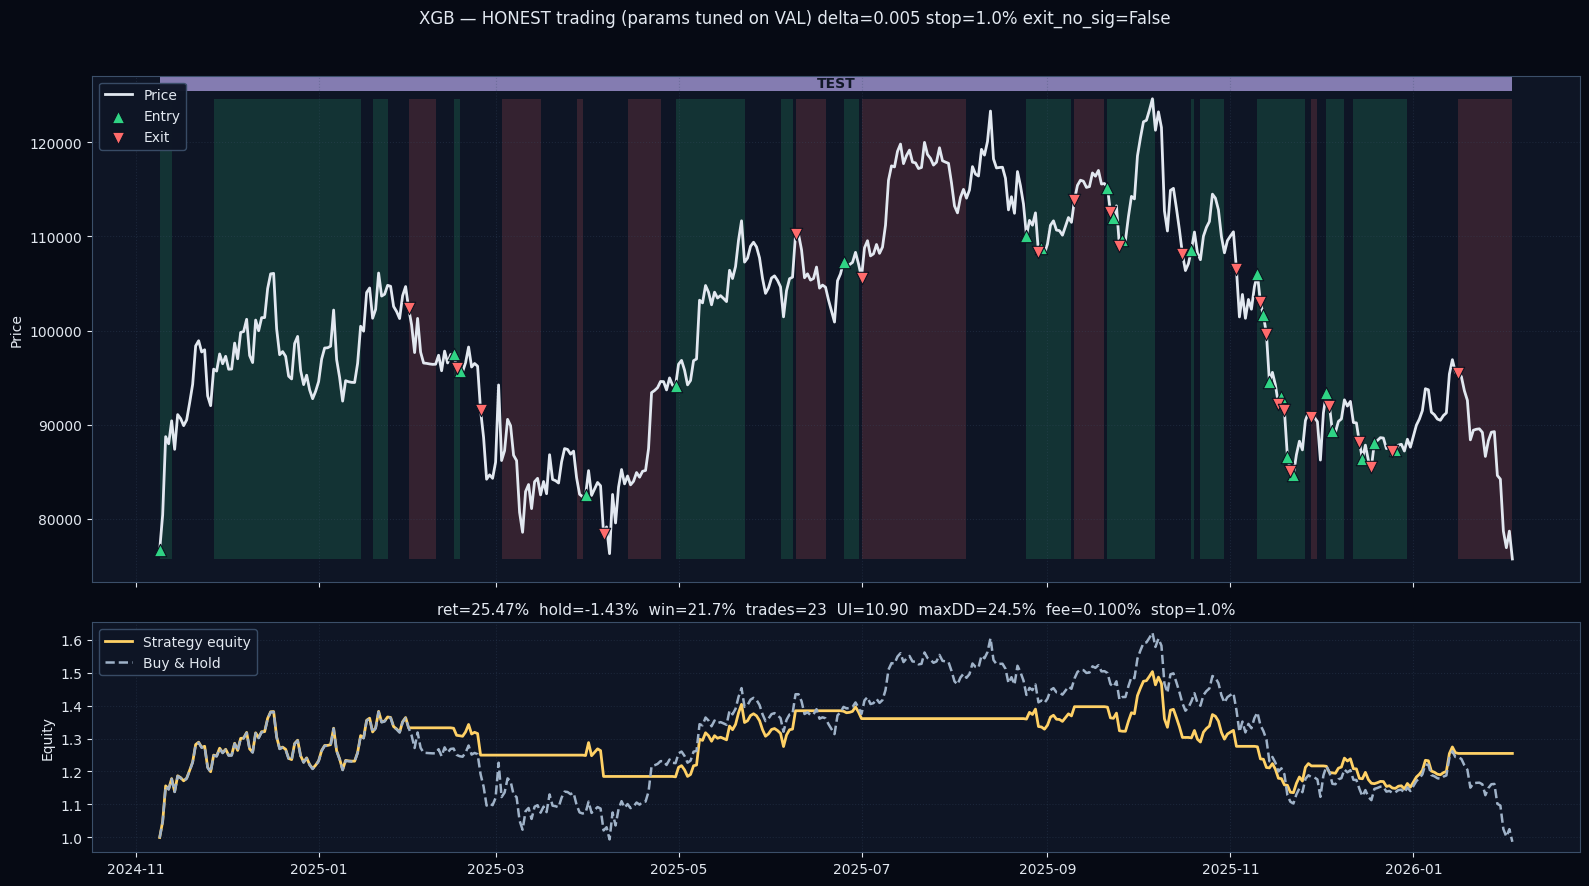

HONEST TRADING TUNE (VAL only) -> APPLY (TEST): rf
[rf] tune 1/60 left=59 delta=0.000 stop=0.000 exit_no_sig=False | VAL ret=26.72% UI=13.21 trades=10 | BEST score=0.02023
[rf] tune 20/60 left=40 delta=0.005 stop=0.030 exit_no_sig=True | VAL ret=18.60% UI=13.52 trades=14 | BEST score=0.06386
[rf] tune 40/60 left=20 delta=0.020 stop=0.010 exit_no_sig=True | VAL ret=23.49% UI=6.92 trades=14 | BEST score=0.08262
[rf] tune 60/60 left=0 delta=0.030 stop=0.080 exit_no_sig=True | VAL ret=19.13% UI=8.10 trades=7 | BEST score=0.1158


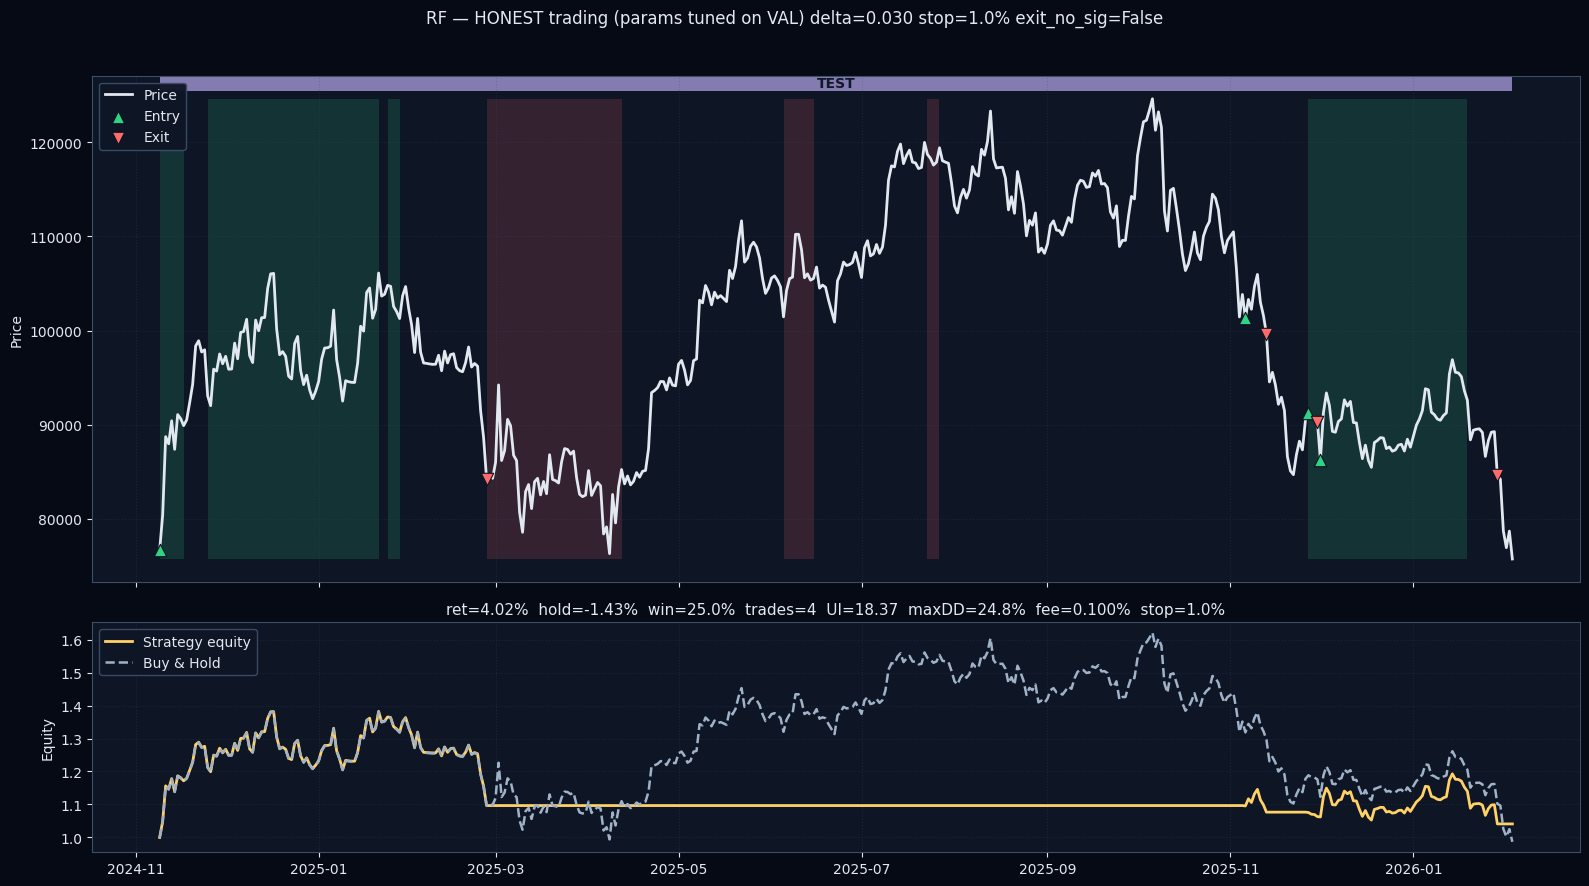

HONEST TRADING TUNE (VAL only) -> APPLY (TEST): sklearn_mlp
[sklearn_mlp] tune 1/60 left=59 delta=0.000 stop=0.000 exit_no_sig=False | VAL ret=5.51% UI=16.12 trades=64 | BEST score=0.003416
[sklearn_mlp] tune 20/60 left=40 delta=0.005 stop=0.030 exit_no_sig=True | VAL ret=-3.89% UI=18.74 trades=69 | BEST score=0.003416
[sklearn_mlp] tune 40/60 left=20 delta=0.020 stop=0.010 exit_no_sig=True | VAL ret=6.24% UI=17.96 trades=72 | BEST score=0.00445
[sklearn_mlp] tune 60/60 left=0 delta=0.030 stop=0.080 exit_no_sig=True | VAL ret=4.43% UI=17.36 trades=63 | BEST score=0.00445


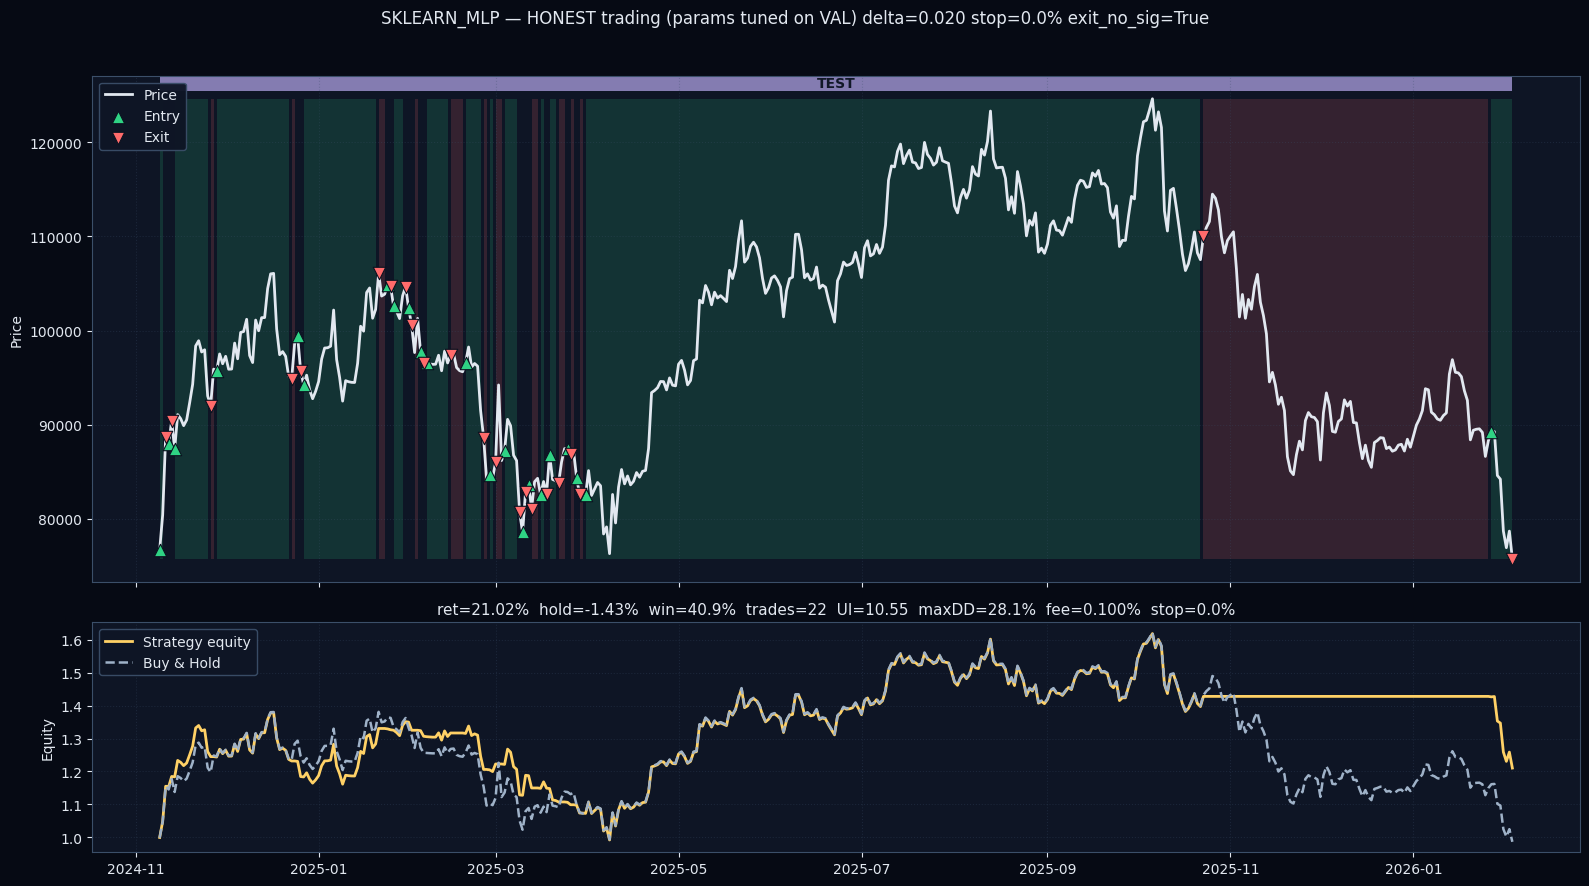

HONEST TRADING TUNE (VAL only) -> APPLY (TEST): keras_mlp
[keras_mlp] tune 1/60 left=59 delta=0.000 stop=0.000 exit_no_sig=False | VAL ret=155.01% UI=10.41 trades=11 | BEST score=0.1489
[keras_mlp] tune 20/60 left=40 delta=0.005 stop=0.030 exit_no_sig=True | VAL ret=166.17% UI=10.56 trades=15 | BEST score=0.1957
[keras_mlp] tune 40/60 left=20 delta=0.020 stop=0.010 exit_no_sig=True | VAL ret=139.76% UI=12.94 trades=23 | BEST score=0.1966
[keras_mlp] tune 60/60 left=0 delta=0.030 stop=0.080 exit_no_sig=True | VAL ret=131.77% UI=13.99 trades=15 | BEST score=0.1966


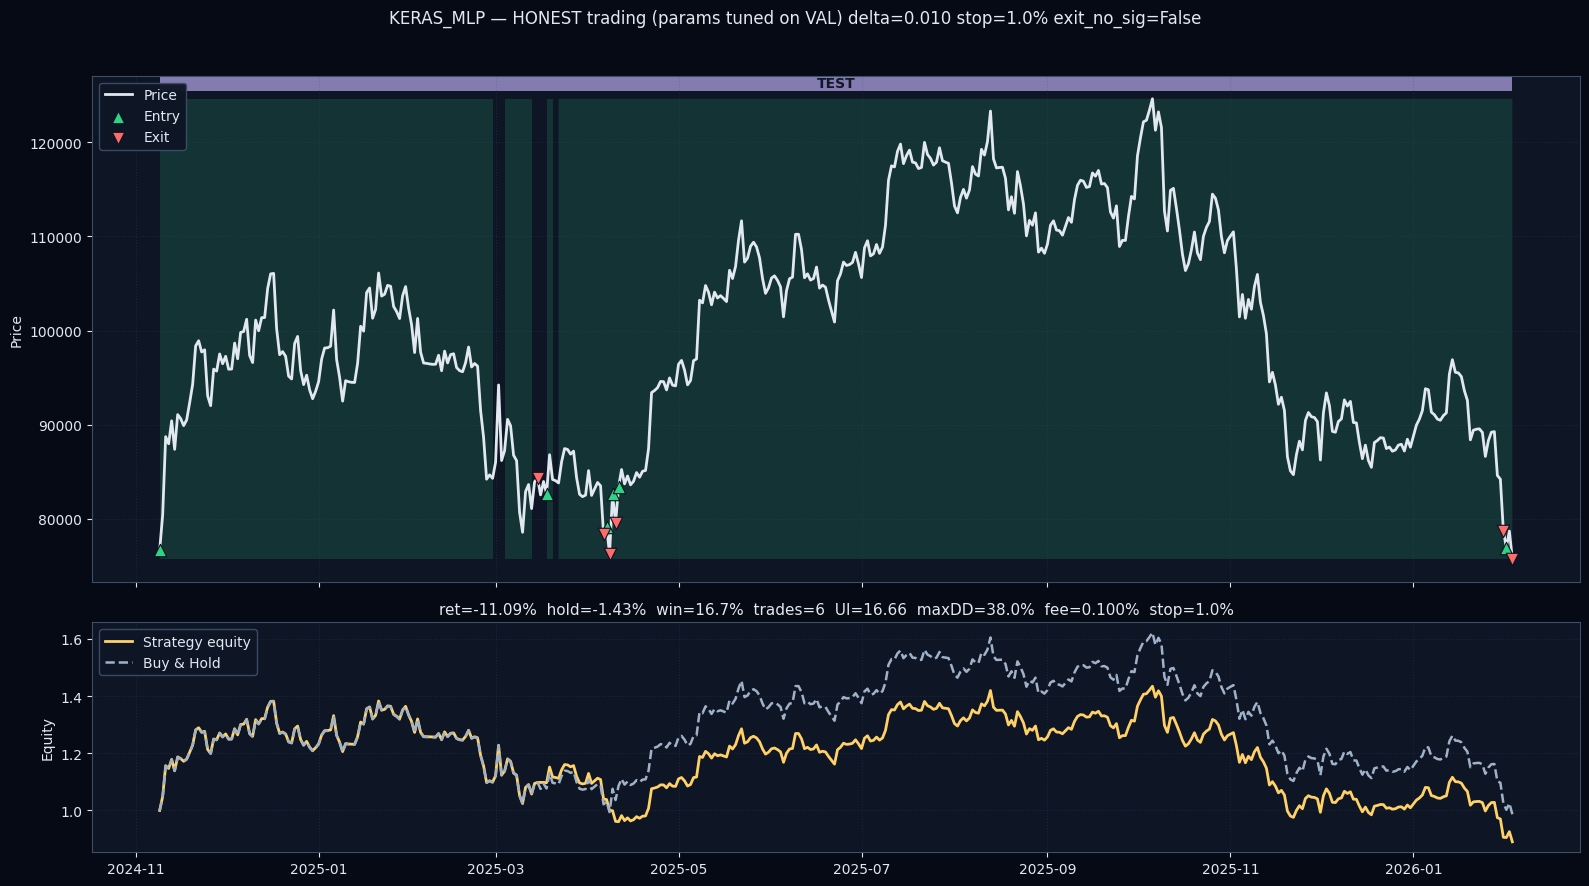

Trading comparison (params tuned on VAL, evaluated on TEST):


,model,delta,stop_loss_pct,exit_on_no_signal,val_return_pct,val_ulcer,val_uarr,val_trades,test_return_pct,test_hold_return_pct,test_excess_return_pct,test_ulcer,test_uarr,test_trades,test_max_dd_pct,test_exposure_pct
0,xgb,0.005,0.01,False,1.931745,4.666924,0.413923,26,0.254654,-0.014269,0.272816,10.901154,0.023360,23,24.497777,55.088496
1,sklearn_mlp,0.020,0.00,True,0.071652,16.102755,0.004450,63,0.210167,-0.014269,0.227685,10.546568,0.019928,22,28.089270,69.911504
2,rf,0.030,0.01,False,0.840274,7.254916,0.115821,9,0.040205,-0.014269,0.055263,18.367805,0.002189,4,24.762729,39.380531
3,keras_mlp,0.010,0.01,False,1.939146,9.865779,0.196553,12,-0.110923,-0.014269,-0.098053,16.660820,-0.006658,6,38.017531,98.230088


In [7]:
# -------------------------------------------
# Train models, run honest trading, compare
# -------------------------------------------

preds = {}

print('Training XGB...')
preds['xgb'] = _train_predict_xgb(train_df, val_df, test_df)

print('Training RF...')
preds['rf'] = _train_predict_rf(train_df, val_df, test_df)

print('Training sklearn MLP...')
preds['sklearn_mlp'] = _train_predict_sklearn_mlp(train_df, val_df, test_df, seed=42)

print('Training keras MLP...')
preds['keras_mlp'] = _train_predict_keras_mlp(train_df, val_df, test_df, seed=42)

# Classification report (threshold tuned on validation).
cls_rows = []
for name, df_pred in preds.items():
    cls_rows.append(eval_classification_with_val_threshold(df_pred, model_name=name))

df_cls = pd.DataFrame(cls_rows).sort_values(['val_recall_min','val_recall_gap','val_mcc','val_accuracy'], ascending=[False, True, False, False])
print('Classification comparison (val-threshold, sorted by val rule):')
display(df_cls[[
    'model','val_threshold',
    'val_accuracy','val_mcc','val_recall_min','val_recall_gap','val_p_value_vs_random',
    'test_accuracy','test_mcc','test_recall_min','test_recall_gap','test_p_value_vs_random',
]])

# Honest trading: tune on VAL, apply once on TEST.
trading_rows = []
best_trading = {}

for name, df_pred in preds.items():
    print('' + '=' * 120)
    print('HONEST TRADING TUNE (VAL only) -> APPLY (TEST):', name)
    best = tune_trading_on_validation(
        pred_all=df_pred,
        model_name=name,
        fee_rate=FEE_RATE,
        stop_losses=STOP_LOSSES,
        exit_on_no_signal_options=EXIT_ON_NO_SIGNAL_OPTIONS,
        neutral_deltas=NEUTRAL_DELTAS,
    )
    best_trading[name] = best

    row = {
        'model': name,
        'delta': best['delta'],
        'stop_loss_pct': best['stop_loss_pct'],
        'exit_on_no_signal': best['exit_on_no_signal'],
        'val_return_pct': best['val_metrics']['return_pct'],
        'val_ulcer': best['val_metrics']['ulcer_index'],
        'val_uarr': best['val_metrics']['ulcer_adjusted_return'],
        'val_trades': best['val_metrics']['num_trades'],
        'test_return_pct': best['test_metrics']['return_pct'],
        'test_hold_return_pct': best['test_metrics']['hold_return_pct'],
        'test_excess_return_pct': best['test_metrics']['excess_return_pct'],
        'test_ulcer': best['test_metrics']['ulcer_index'],
        'test_uarr': best['test_metrics']['ulcer_adjusted_return'],
        'test_trades': best['test_metrics']['num_trades'],
        'test_max_dd_pct': best['test_metrics']['max_drawdown_pct'],
        'test_exposure_pct': best['test_metrics']['exposure_pct'],
    }
    trading_rows.append(row)

    # Plot the TEST equity for the chosen params.
    plot_backtest_price_and_equity(
        best['test_run'],
        title=(
            f"{name.upper()} — HONEST trading (params tuned on VAL) "
            f"delta={best['delta']:.3f} stop={best['stop_loss_pct']:.1%} exit_no_sig={best['exit_on_no_signal']}"
        ),
        vis_cfg=VIS_CFG,
    )

df_trading = pd.DataFrame(trading_rows).sort_values(['test_uarr','test_return_pct'], ascending=[False, False]).reset_index(drop=True)
print('Trading comparison (params tuned on VAL, evaluated on TEST):')
display(df_trading)

In [8]:
# -------------------------------------------
# Stability check for NNs (multiple seeds)
# -------------------------------------------
#
# If the "edge" is real, NN results should be somewhat stable
# across random seeds. If the result jumps wildly, it is a red flag.

SEEDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

def run_seed_stability(kind: str) -> pd.DataFrame:
    rows = []
    for seed in SEEDS:
        if kind == 'sklearn_mlp':
            df_pred = _train_predict_sklearn_mlp(train_df, val_df, test_df, seed=int(seed))
        elif kind == 'keras_mlp':
            df_pred = _train_predict_keras_mlp(train_df, val_df, test_df, seed=int(seed))
        else:
            raise ValueError('unknown kind')

        # Tune trading params on VAL, apply to TEST.
        best = tune_trading_on_validation(
            pred_all=df_pred,
            model_name=kind,
            fee_rate=FEE_RATE,
            stop_losses=STOP_LOSSES,
            exit_on_no_signal_options=EXIT_ON_NO_SIGNAL_OPTIONS,
            neutral_deltas=NEUTRAL_DELTAS,
        )

        rows.append({
            'seed': int(seed),
            'delta': best['delta'],
            'stop_loss_pct': best['stop_loss_pct'],
            'exit_on_no_signal': best['exit_on_no_signal'],
            'val_uarr': best['val_metrics']['ulcer_adjusted_return'],
            'test_uarr': best['test_metrics']['ulcer_adjusted_return'],
            'test_return_pct': best['test_metrics']['return_pct'],
            'test_excess_return_pct': best['test_metrics']['excess_return_pct'],
            'test_ulcer': best['test_metrics']['ulcer_index'],
            'test_trades': best['test_metrics']['num_trades'],
        })

        print(f'[{kind}] seed={seed} -> test_ret={rows[-1]["test_return_pct"]:.2%} test_uarr={rows[-1]["test_uarr"]:.4g}')

    return pd.DataFrame(rows)


df_sklearn = run_seed_stability('sklearn_mlp')
df_keras = run_seed_stability('keras_mlp')

print('Seed stability summary (sklearn_mlp):')
display(df_sklearn.describe(include='all'))
print('Seed stability summary (keras_mlp):')
display(df_keras.describe(include='all'))

[sklearn_mlp] tune 1/60 left=59 delta=0.000 stop=0.000 exit_no_sig=False | VAL ret=-6.50% UI=21.74 trades=64 | BEST score=-0.002989
[sklearn_mlp] tune 20/60 left=40 delta=0.005 stop=0.030 exit_no_sig=True | VAL ret=-18.45% UI=24.44 trades=75 | BEST score=-0.002989
[sklearn_mlp] tune 40/60 left=20 delta=0.020 stop=0.010 exit_no_sig=True | VAL ret=-11.81% UI=19.32 trades=87 | BEST score=-0.002989
[sklearn_mlp] tune 60/60 left=0 delta=0.030 stop=0.080 exit_no_sig=True | VAL ret=-14.40% UI=24.30 trades=63 | BEST score=-0.002989
[sklearn_mlp] seed=1 -> test_ret=-23.32% test_uarr=-0.007648
[sklearn_mlp] tune 1/60 left=59 delta=0.000 stop=0.000 exit_no_sig=False | VAL ret=29.87% UI=13.00 trades=65 | BEST score=0.02297
[sklearn_mlp] tune 20/60 left=40 delta=0.005 stop=0.030 exit_no_sig=True | VAL ret=17.00% UI=15.88 trades=71 | BEST score=0.02297
[sklearn_mlp] tune 40/60 left=20 delta=0.020 stop=0.010 exit_no_sig=True | VAL ret=28.31% UI=12.09 trades=77 | BEST score=0.02421
[sklearn_mlp] tune 

,seed,delta,stop_loss_pct,exit_on_no_signal,val_uarr,test_uarr,test_return_pct,test_excess_return_pct,test_ulcer,test_trades
count,10.00000,10.000000,10.000000,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.50000,0.010000,0.005000,NaN,0.029251,0.023955,0.081554,0.097210,19.915370,27.800000
std,3.02765,0.010541,0.008498,NaN,0.044037,0.062050,0.350817,0.355895,9.697232,10.315038
min,1.00000,0.000000,0.000000,NaN,-0.003303,-0.011408,-0.369076,-0.359942,4.359224,15.000000
25%,3.25000,0.000000,0.000000,NaN,0.001257,-0.006180,-0.175499,-0.163563,13.689530,21.500000
50%,5.50000,0.010000,0.000000,NaN,0.004725,0.003389,0.059143,0.074475,22.189187,26.500000
75%,7.75000,0.017500,0.007500,NaN,0.040481,0.019208,0.246589,0.264634,27.580930,28.750000


Seed stability summary (keras_mlp):


,seed,delta,stop_loss_pct,exit_on_no_signal,val_uarr,test_uarr,test_return_pct,test_excess_return_pct,test_ulcer,test_trades
count,10.00000,10.000000,10.000000,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.50000,0.021000,0.010000,NaN,0.225499,0.018168,0.134171,0.150589,10.483923,12.800000
std,3.02765,0.009944,0.014907,NaN,0.169068,0.021864,0.189846,0.192594,3.471520,11.311744
min,1.00000,0.000000,0.000000,NaN,-0.008640,-0.012717,-0.193939,-0.182270,5.076627,3.000000
25%,3.25000,0.020000,0.000000,NaN,0.139559,0.004344,0.050763,0.065974,7.636984,6.250000
50%,5.50000,0.020000,0.010000,NaN,0.213078,0.015140,0.149165,0.165800,10.552348,8.500000
75%,7.75000,0.030000,0.010000,NaN,0.278857,0.031586,0.238956,0.256891,13.409810,12.500000
